In [ ]:
# Imports here
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torch import optim
from collections import OrderedDict
from time import time
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import skimage.io as io
import os
import copy
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:

data_dir = '/kaggle/input/satellite-image-classification'
train_dir = data_dir + '/data'

# Define your transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load all the images from the train folder
all_data = datasets.ImageFolder(train_dir, transform=train_transforms)

# Calculate the sizes for train, validation, and test sets
total_size = len(all_data)
train_size = int(0.7 * total_size)
test_size = int(0.15 * total_size)
valid_size = total_size - train_size - test_size

# Use random_split to split the dataset
train_data, valid_data, test_data = torch.utils.data.random_split(all_data, [train_size, valid_size, test_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)


In [3]:
# Load a pre-trained network 
model = models.alexnet(pretrained=True)
model.name = "alexnet"
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 241MB/s]  


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [9]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(9216, 4096, bias=True)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(4096, 4, bias=True)),
                          ('output', nn.LogSoftmax(dim=1)) # Use nn.Softmax if Loss is CrossEntropy
                          ]))
    
model.classifier = classifier

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
!pip install torchsummary

  Obtaining dependency information for torchsummary from https://files.pythonhosted.org/packages/7d/18/1474d06f721b86e6a9b9d7392ad68bed711a02f3b61ac43f13c719db50a6/torchsummary-1.5.1-py3-none-any.whl.metadata


In [ ]:
from torchsummary import summary
summary(model.to(device),(3,224,224))

In [12]:
# change to device
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu1): ReLU()
    (dropout1): Dr

In [14]:
# Define loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Define deep learning method
epochs = 5
print_every = 30 # Prints every 30 images out of batch of 50 images
steps = 0

In [15]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        # Uncomment below line if gpu is available
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [16]:
def train(model,steps,print_every,epochs):
    print("Training process initializing .....\n")

    for e in range(epochs):
        running_loss = 0
        model.train() 
    
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
        
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                model.eval()

                with torch.no_grad():
                    valid_loss, accuracy = validation(model, validloader, criterion)
            
                print("Epoch: {}/{} | ".format(e+1, epochs),
                      "Training Loss: {:.4f} | ".format(running_loss/print_every),
                      "Validation Loss: {:.4f} | ".format(valid_loss/len(validloader)),
                      "Validation Accuracy: {:.4f}".format(accuracy/len(validloader)))
            
                running_loss = 0
                model.train()

    print("\nTraining process is now complete!!")
    return model

In [17]:
model = train(model,steps,print_every,epochs)

Training process initializing .....

Epoch: 1/5 |  Training Loss: 0.5072 |  Validation Loss: 0.2863 |  Validation Accuracy: 0.9223
Epoch: 1/5 |  Training Loss: 0.1604 |  Validation Loss: 0.1570 |  Validation Accuracy: 0.9550
Epoch: 2/5 |  Training Loss: 0.0925 |  Validation Loss: 0.0836 |  Validation Accuracy: 0.9753
Epoch: 2/5 |  Training Loss: 0.1709 |  Validation Loss: 0.2314 |  Validation Accuracy: 0.9398
Epoch: 2/5 |  Training Loss: 0.1676 |  Validation Loss: 0.1479 |  Validation Accuracy: 0.9646
Epoch: 3/5 |  Training Loss: 0.0953 |  Validation Loss: 0.0800 |  Validation Accuracy: 0.9800
Epoch: 3/5 |  Training Loss: 0.1240 |  Validation Loss: 0.1249 |  Validation Accuracy: 0.9753
Epoch: 4/5 |  Training Loss: 0.0130 |  Validation Loss: 0.1120 |  Validation Accuracy: 0.9752
Epoch: 4/5 |  Training Loss: 0.2543 |  Validation Loss: 0.3503 |  Validation Accuracy: 0.9528
Epoch: 4/5 |  Training Loss: 0.3033 |  Validation Loss: 0.1319 |  Validation Accuracy: 0.9824
Epoch: 5/5 |  Training 

In [18]:
def pred(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [19]:
labels,predictions = pred(model,testloader)

Time:  7.271549463272095
Accuracy achieved by the network on test images is: 98%


In [20]:
def metrics(labels,predictions):
    classes = train_data.dataset.classes
    cm = confusion_matrix(np.array(labels), np.array(predictions))
    print("Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print('----------------------------------------------------------------')
    print("Classification Report:")
    report = classification_report(np.array(labels),np.array(predictions))
    print(report)

Confusion Matrix:


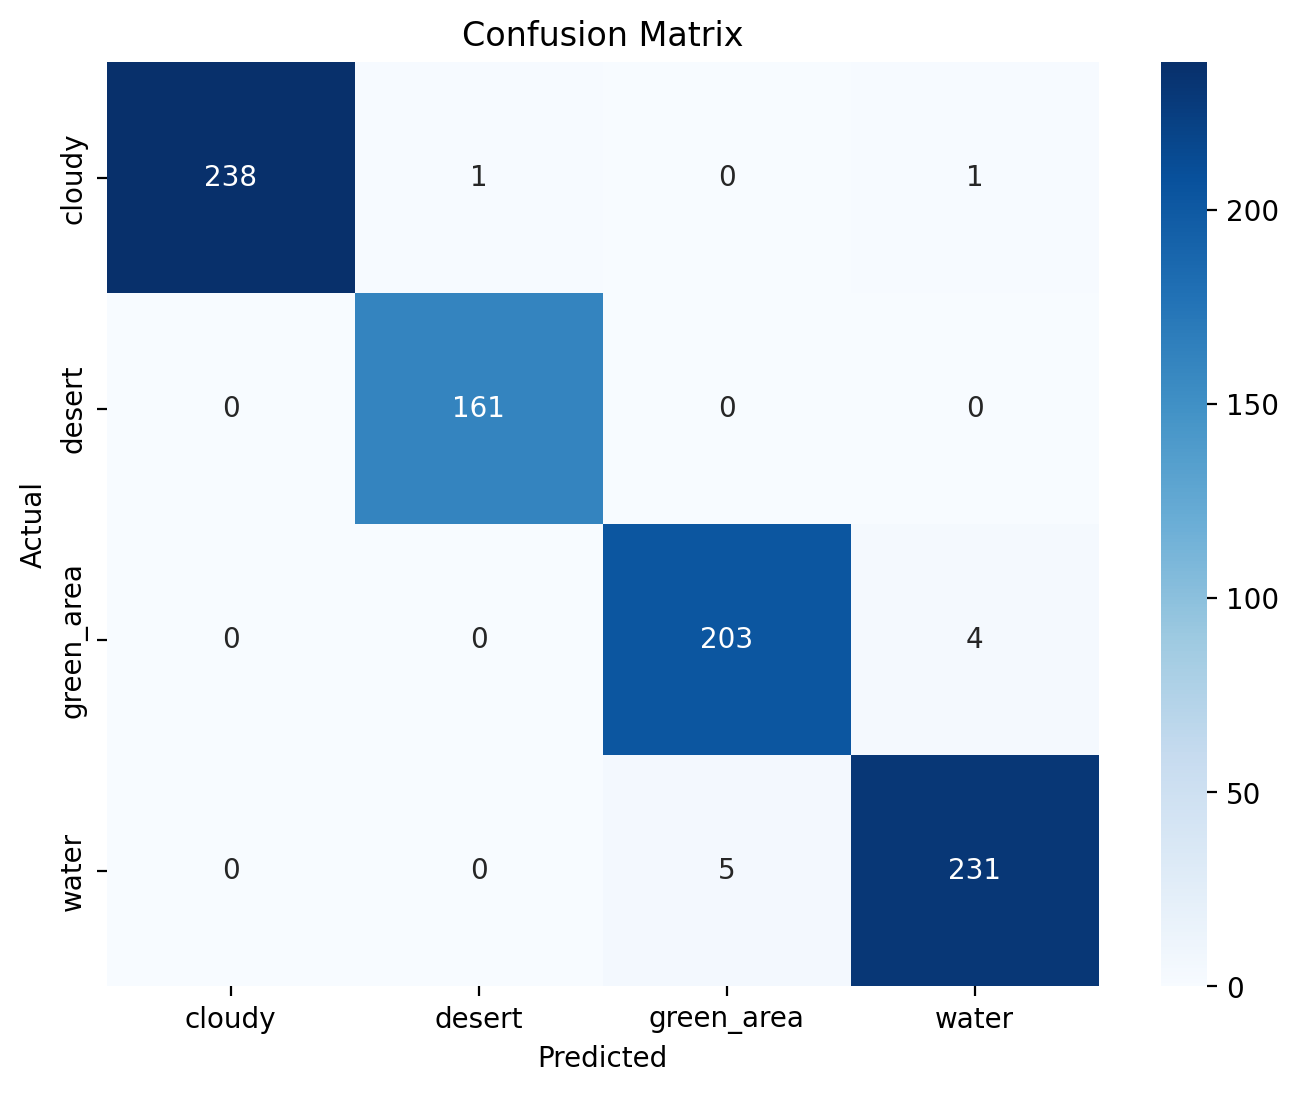

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       240
           1       0.99      1.00      1.00       161
           2       0.98      0.98      0.98       207
           3       0.98      0.98      0.98       236

    accuracy                           0.99       844
   macro avg       0.99      0.99      0.99       844
weighted avg       0.99      0.99      0.99       844



In [21]:
metrics(labels,predictions)

# QUANTIZATION

In [23]:
model_fp16 = copy.deepcopy(model)

In [ ]:
model_fp16.half()

In [25]:
weights_half = model_fp16.state_dict()
print(weights_half['features.0.weight'].dtype)

torch.float16


In [26]:
model_fp16.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu1): ReLU()
    (dropout1): Dr

In [35]:
def pred_fp16(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.half())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [29]:
labels,predictions = pred_fp16(model_fp16,testloader)

Time:  3.4307005405426025
Accuracy achieved by the network on test images is: 99%


Confusion Matrix:


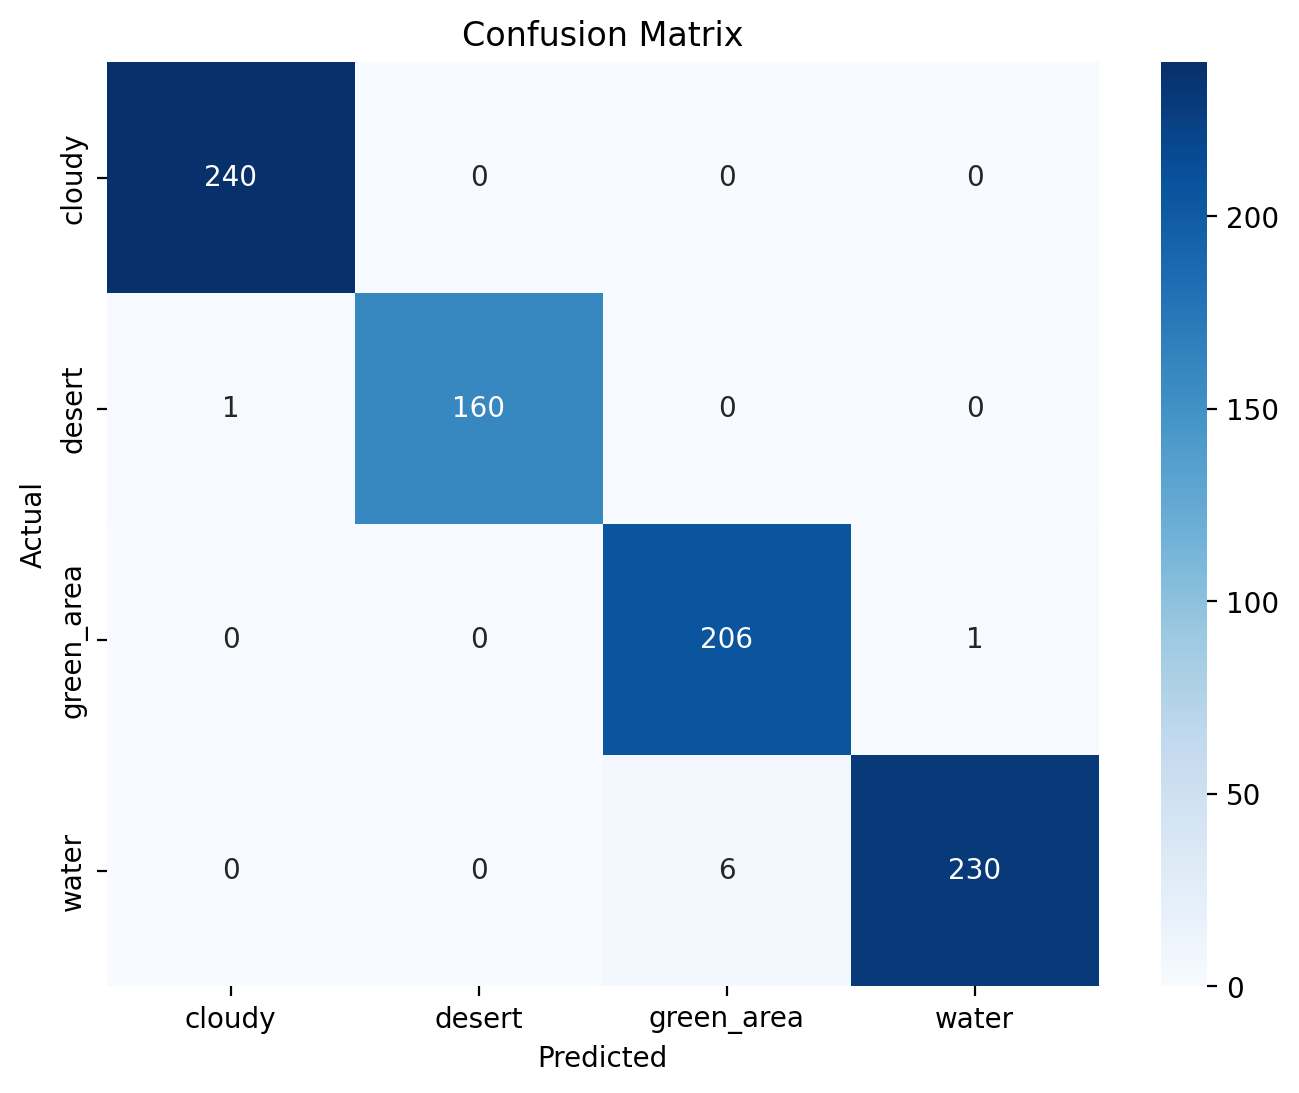

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      0.99      1.00       161
           2       0.97      1.00      0.98       207
           3       1.00      0.97      0.99       236

    accuracy                           0.99       844
   macro avg       0.99      0.99      0.99       844
weighted avg       0.99      0.99      0.99       844



In [30]:
metrics(labels,predictions)

# FP-64

In [ ]:
model_64 = copy.deepcopy(model)
model_64.double()

In [32]:
weights_64 = model_64.state_dict()
print(weights_64['features.0.weight'].dtype)

torch.float64


In [33]:
model_64.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu1): ReLU()
    (dropout1): Dr

In [34]:
def pred_fp64(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.double())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [38]:
 labels,predictions = pred_fp64(model_64,testloader)

Time:  13.581934213638306
Accuracy achieved by the network on test images is: 98%


Confusion Matrix:


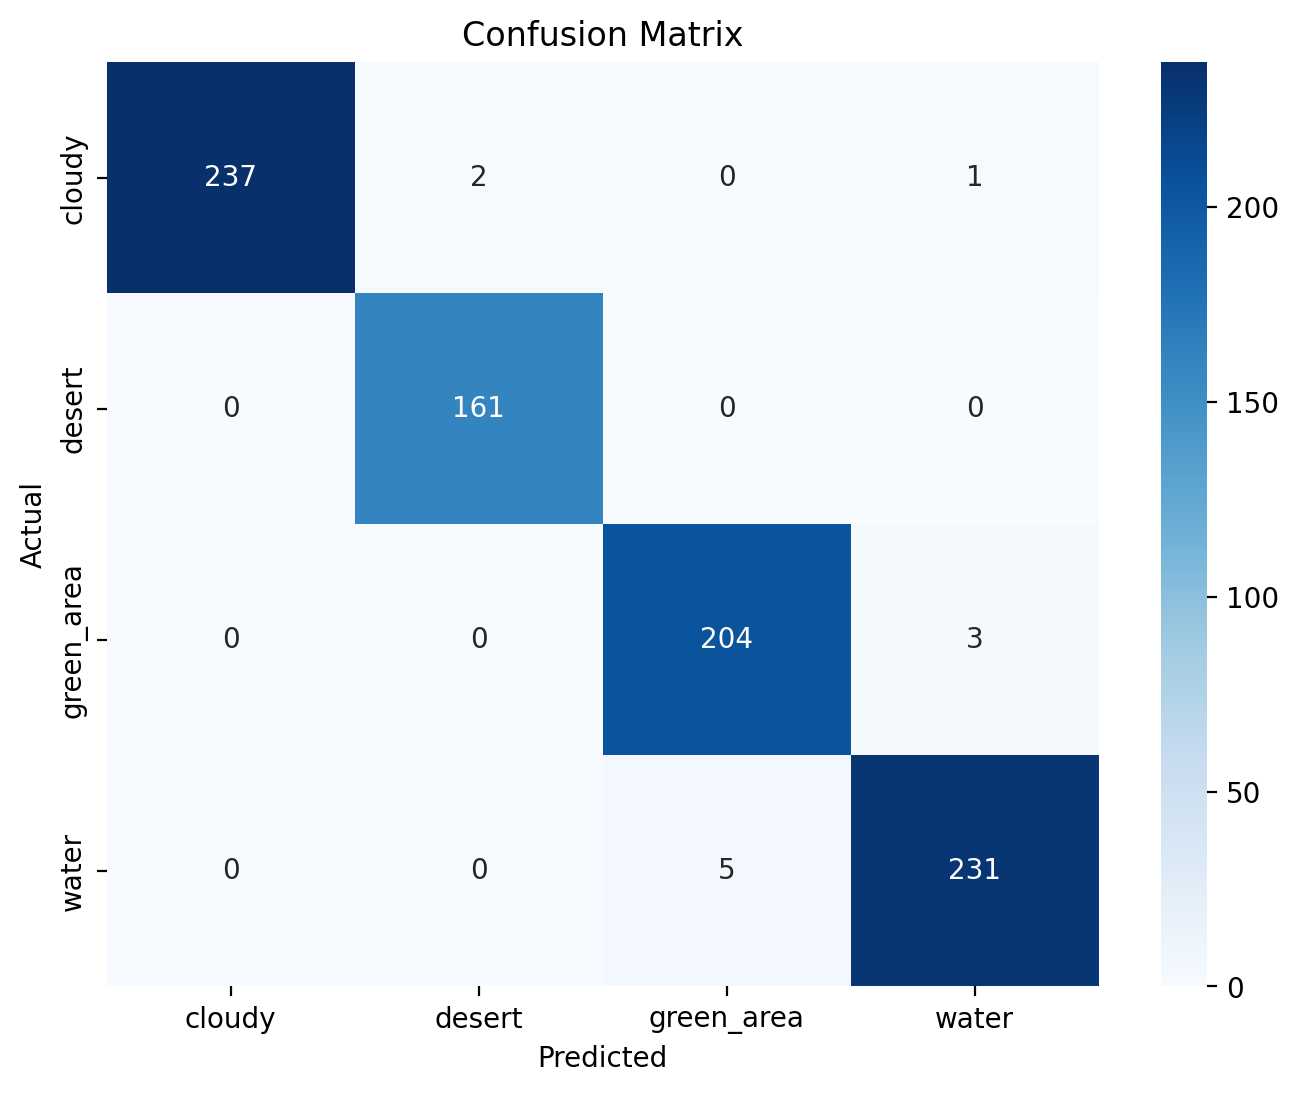

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       240
           1       0.99      1.00      0.99       161
           2       0.98      0.99      0.98       207
           3       0.98      0.98      0.98       236

    accuracy                           0.99       844
   macro avg       0.99      0.99      0.99       844
weighted avg       0.99      0.99      0.99       844



In [39]:
metrics(labels,predictions)

## INT-8

In [41]:
from torch.ao.quantization import QuantStub, DeQuantStub
import torch
from torch.ao.quantization import (
  get_default_qconfig_mapping,
  get_default_qat_qconfig_mapping,
  QConfigMapping,
)
import torch.ao.quantization.quantize_fx as quantize_fx

### PTQ

In [42]:
model_fp32 = copy.deepcopy(model)

In [ ]:
model_fp32.to('cpu')

In [44]:
input_data = next(iter(trainloader))[0]
calibrate_data = input_data.to("cpu")

In [45]:
model_int8 = copy.deepcopy(model_fp32)
#model_int8.to(device)
qconfig_mapping = get_default_qconfig_mapping("qnnpack")
model_int8.eval()
# prepare
model_prepared = quantize_fx.prepare_fx(model_int8, qconfig_mapping, calibrate_data)
# calibrate 

In [46]:
with torch.no_grad():
    for i in range(20):
        batch = next(iter(trainloader))[0]
        output = model_prepared(batch.to('cpu'))

In [47]:
model_quantized_static = quantize_fx.convert_fx(model_prepared)

In [66]:
model_quantized_static.to('cpu')

GraphModule(
  (features): Module(
    (0): QuantizedConvReLU2d(3, 64, kernel_size=(11, 11), stride=(4, 4), scale=0.09054233878850937, zero_point=0, padding=(2, 2))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): QuantizedConvReLU2d(64, 192, kernel_size=(5, 5), stride=(1, 1), scale=0.19043809175491333, zero_point=0, padding=(2, 2))
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): QuantizedConvReLU2d(192, 384, kernel_size=(3, 3), stride=(1, 1), scale=0.13451653718948364, zero_point=0, padding=(1, 1))
    (8): QuantizedConvReLU2d(384, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.1333240419626236, zero_point=0, padding=(1, 1))
    (10): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.08818456530570984, zero_point=0, padding=(1, 1))
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (c

In [49]:
all_labels_int8 = []
all_predictions_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_static.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_static(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)

print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  7.703434944152832
Accuracy achieved by the network on test images is: 95%


Confusion Matrix:


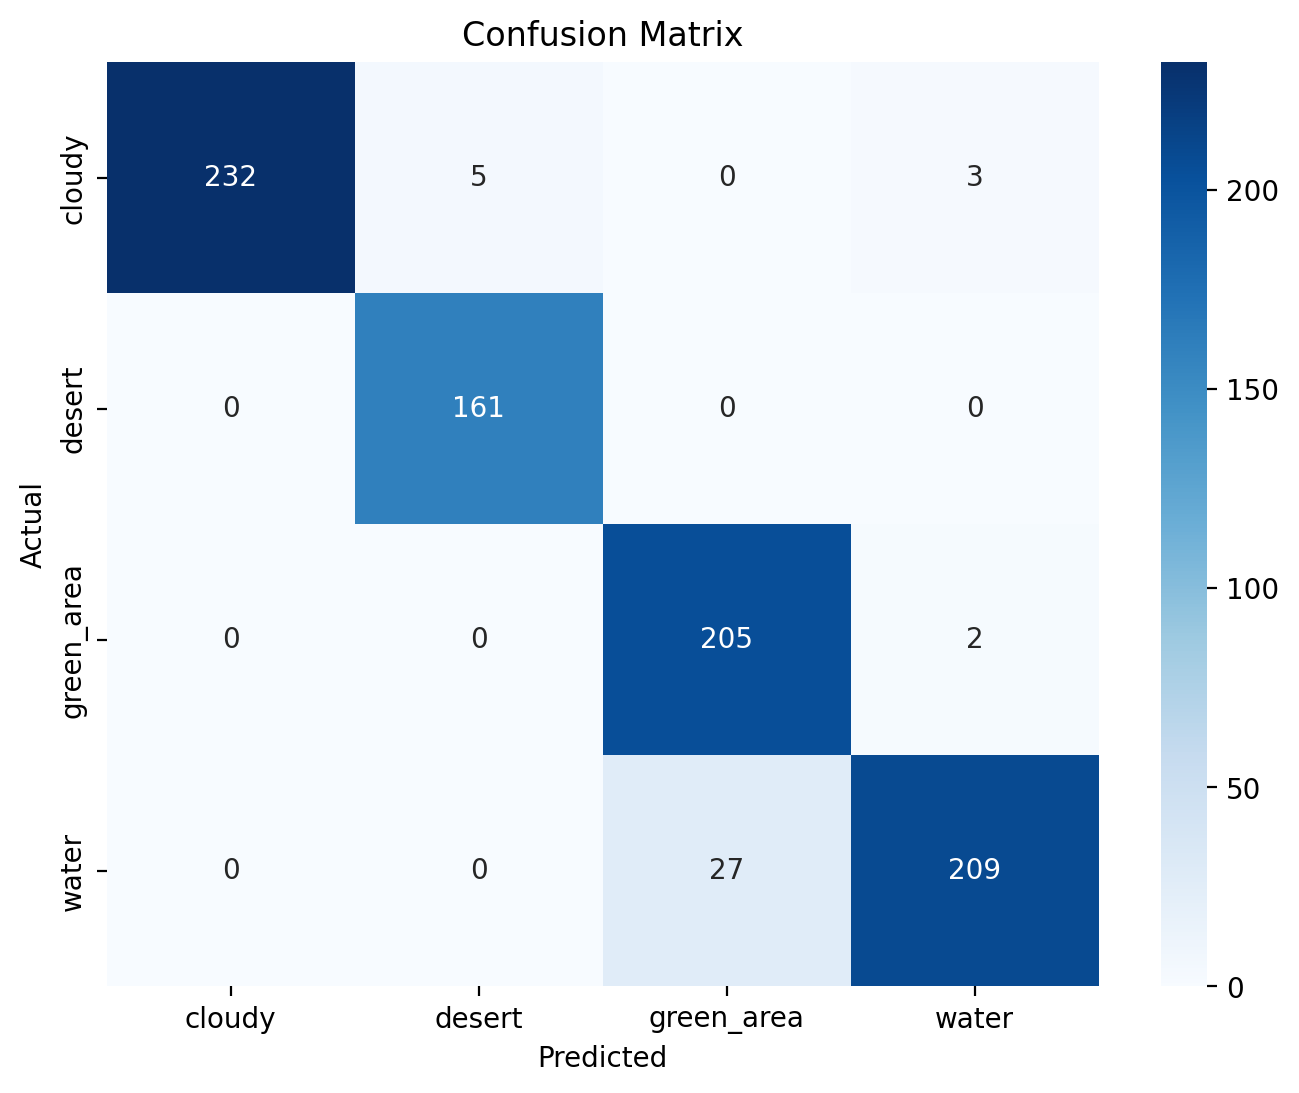

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       240
           1       0.97      1.00      0.98       161
           2       0.88      0.99      0.93       207
           3       0.98      0.89      0.93       236

    accuracy                           0.96       844
   macro avg       0.96      0.96      0.96       844
weighted avg       0.96      0.96      0.96       844



In [50]:
metrics(all_labels_int8,all_predictions_int8)

QAT

In [51]:
import os
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [52]:
print("FP64 model size:",end='')
print_model_size(model_64)
print("FP32 model size:",end='')
print_model_size(model)
print("FP16 model size:",end='')
print_model_size(model_fp16)
print("INT8 model size:",end='')
print_model_size(model_quantized_static)

FP64 model size:321.92 MB
FP32 model size:160.96 MB
FP16 model size:80.48 MB
INT8 model size:40.26 MB
